## Setup

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import json

import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import F1Score, Accuracy

import lightning as L
import random
import pickle

from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from utils import *

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("data/sub_1000.json","r") as j_file:
    data = json.load(j_file)

## HAE

In [3]:
split_ratios = [0.7, 0.15, 0.15]

random.shuffle(data)
train_data, val_data, test_data = split_list(data, split_ratios)

print(f"""
train: {len(train_data)}
  val: {len(val_data)}
 test: {len(test_data)}
""")


train: 700
  val: 150
 test: 150



In [4]:
### load embeddings ###
with open('data/text2embeddings.pkl', 'rb') as f:
    text2embeddings = pickle.load(f)

### setup dataloaders ###
train_ds, val_ds, test_ds = PatientDataset(train_data, text2embeddings), PatientDataset(val_data, text2embeddings), PatientDataset(test_data, text2embeddings)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=collate_fn, num_workers=5, persistent_workers=True)
val_dl = DataLoader(val_ds, batch_size=10, collate_fn=collate_fn, num_workers=5, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=10, collate_fn=collate_fn, num_workers=5)

model = PatientAutoencoder()

logger = CSVLogger("pl_logs_tmp", name="hae")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=100,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_mse", mode="min", save_last=True, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="hae-{epoch:02d}-{val_mse:.2f}"
        ),
        EarlyStopping(monitor="val_mse", patience=3, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                  | Type                 | Params
----------------------------------------

Epoch 15: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s, v_num=9, train_mse=0.000328, train_mae=0.00926, val_mse=7.77e-6, val_mae=0.00217]


array([[<Axes: >, <Axes: >]], dtype=object)

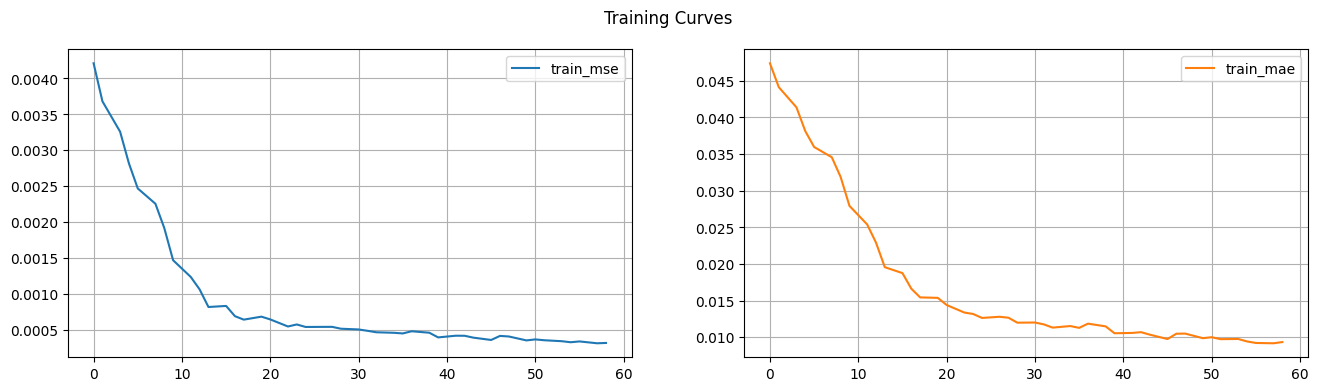

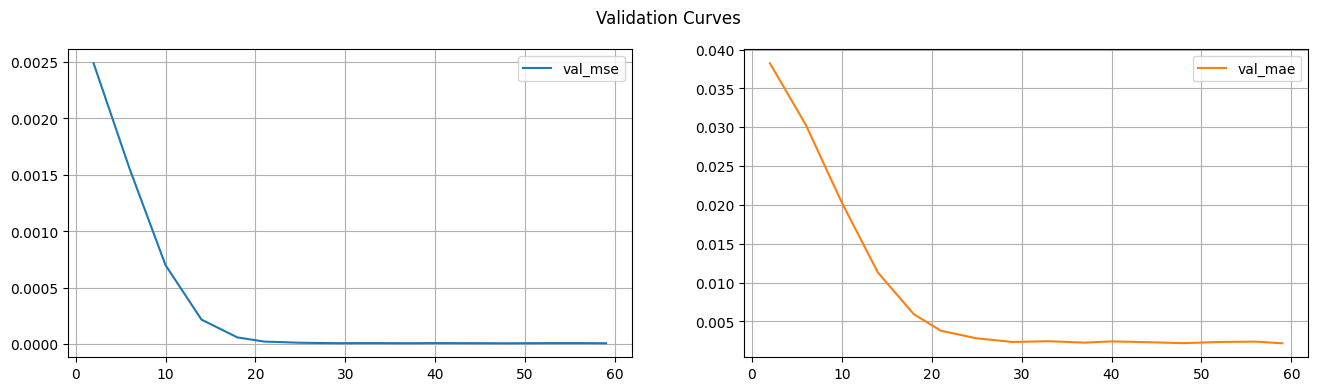

In [5]:
import os
import pandas as pd

num = len(os.listdir("./pl_logs_tmp/hae")) - 1
logs_to_read = f"./pl_logs_tmp/hae/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_mse', 'train_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_mse', 'val_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

## Pre-trained HAE Classifier

In [6]:
split_ratios = [0.7, 0.15, 0.15]

random.shuffle(data)
train_data, val_data, test_data = split_list(data, split_ratios)

print(f"""
train: {len(train_data)}
  val: {len(val_data)}
 test: {len(test_data)}
""")


train: 700
  val: 150
 test: 150



In [7]:
import os

with open('data/text2embeddings.pkl', 'rb') as f:
    text2embeddings = pickle.load(f)

num = len([f for f in os.listdir("./checkpoints_tmp") if 'last' in f]) - 1
pretrained_hae = PatientAutoencoder.load_from_checkpoint(checkpoint_path=f'checkpoints_tmp/last-v{num}.ckpt')
encoder = nn.Sequential(
    pretrained_hae.encounter_autoencoder,
    pretrained_hae.patient_encoder
)

patient_latent_dim = 64  # Final latent space dimension for the patient
classifier_model = PatientClassifier(encoder=encoder, hidden_dim=patient_latent_dim)

train_ds, val_ds, test_ds = PatientDataset(train_data, text2embeddings), PatientDataset(val_data, text2embeddings), PatientDataset(test_data, text2embeddings)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=collate_fn, num_workers=5, persistent_workers=True)
val_dl = DataLoader(val_ds, batch_size=10, collate_fn=collate_fn, num_workers=5, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=10, collate_fn=collate_fn, num_workers=5)

logger = CSVLogger("pl_logs_tmp", name="hae_classifier")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=100,
    accelerator="gpu", # strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="hae_classifier-{epoch:02d}-{val_loss:.2f}"
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
    logger=logger,
    devices=1,
    log_every_n_steps=5
)

trainer.fit(classifier_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type              | Params
----------------------------------------------------
0 | encoder       | Sequential        | 3.0 M 
1 | classifier    | Linear            | 65    
2 | val_acc       | BinaryAccuracy    | 0     
3 | test_acc      | BinaryAccuracy    | 0     
4 | train_acc     | BinaryAccuracy    | 0     
5 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
65        Trainable params
3.0 M     Non-trainable params
3.0 M     Total params
11.912    Total estimated model params siz

Epoch 96: 100%|██████████| 29/29 [00:02<00:00, 11.24it/s, v_num=10, train_loss=0.687, train_acc=0.500, val_loss=0.693, val_acc=0.331]


array([[<Axes: >, <Axes: >]], dtype=object)

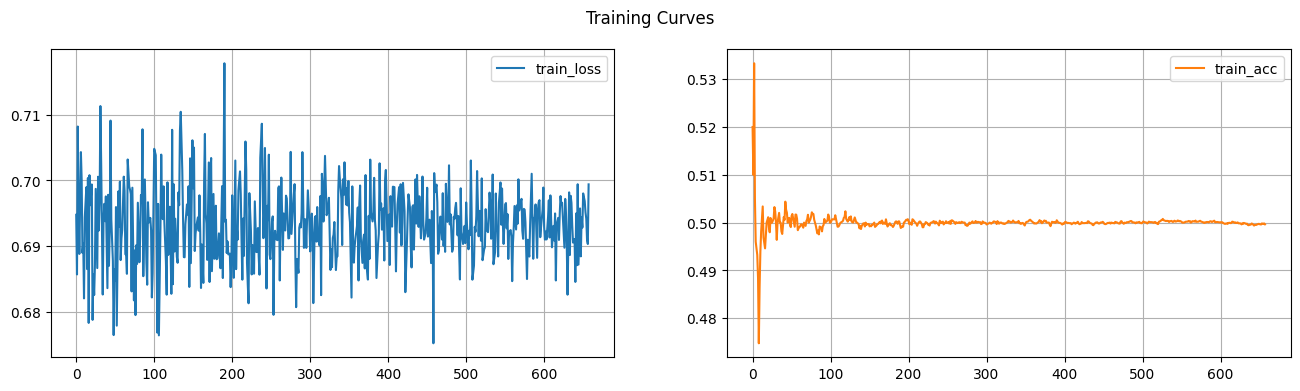

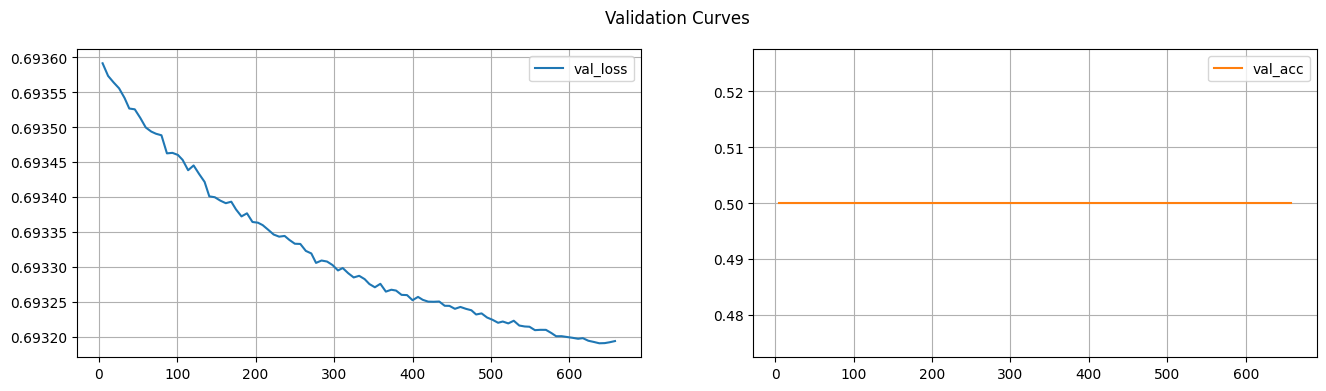

In [8]:
import os
import pandas as pd

num = len(os.listdir("./pl_logs_tmp/hae_classifier")) - 1
logs_to_read = f"./pl_logs_tmp/hae_classifier/version_{num}/metrics.csv"
# logs_to_read = "./pl_logs/hae_classifier/hae_classifier_v1_/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_loss', 'train_acc']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_loss', 'val_acc']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [10]:
trainer.test(classifier_model, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 32.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8133333325386047
        test_loss           0.49087026715278625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.49087026715278625, 'test_acc': 0.8133333325386047}]